# encode training data using a regression network 

In [1]:
import os
import numpy as np 
from tqdm.auto import trange

In [2]:
import spender
from spender.data.sdss import SDSS

In [3]:
import copy
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F 

In [4]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [6]:
dat_dir = '/scratch/network/chhahn/sedflow/training_sed/'
wave = np.load('/scratch/network/chhahn/sedflow/sdss.clean.wave.npy')
spec = np.load(os.path.join(dat_dir, 'train.v0.1.1.seds.nde_noise.npy')).astype(np.float32)
zred = np.load(os.path.join(dat_dir, 'train.v0.1.1.redshifts.npy')).astype(np.float32)
norm = np.empty(spec.shape[0]).astype(np.float32)
for i in range(spec.shape[0]): 
    wave_rest = wave / (1 + zred[i])
    
    sel = (wave_rest > 5300.) & (wave_rest < 5850.)
    norm[i] = np.median(spec[i][sel])

pos_spec = (norm > 0)

spec = (spec/norm[:,None])[pos_spec]
norm = np.log10(norm)[pos_spec]
zred = zred[pos_spec]

ivar = np.load(os.path.join(dat_dir, 'train.v0.1.1.ivar.nde_noise.npy')).astype(np.float32)[pos_spec]
norm_ivar = np.empty(ivar.shape[0]).astype(np.float32)
for i in range(spec.shape[0]): 
    wave_rest = wave / (1 + zred[i])
    
    sel = (wave_rest > 5300.) & (wave_rest < 5850.)
    norm_ivar[i] = np.median(ivar[i][sel])
    
norm_ivar = np.log10(norm_ivar)
ivar /= norm_ivar[:,None]

theta = np.load(os.path.join(dat_dir, 'train.v0.1.1.thetas_unt.npy')).astype(np.float32)[pos_spec]
theta[:,6:8] = np.log10(theta[:,6:8])

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [10]:
sdss = SDSS()

In [11]:
_spec = torch.zeros((spec.shape[0], len(sdss.wave_obs)))

start = int(np.around((np.log10(wave)[0] - torch.log10(sdss.wave_obs[0]).item())/0.0001))
end = min(start+len(np.log10(wave)), len(sdss.wave_obs))

_spec[:,start:end]= torch.from_numpy(spec/norm[:,None])

In [12]:
class SEDflowEncoder(nn.Module):
    """ encoder for SEDflow

    Modified version of spender.SpectrumEncoder, which is a 
    modified version of the encoder by Serrà et al. (2018), which combines a 3 layer CNN
    with a dot-product attention module. This encoder adds a MLP to further compress the
    attended values into a low-dimensional latent space.

    Paper: Serrà et al., https://arxiv.org/abs/1805.03908

    Parameters
    ----------
    instrument: :class:`spender.Instrument`
        Instrument that observed the data
    n_latent: int
        Dimension of latent space
    n_hidden: list of int
        Dimensions for every hidden layer of the :class:`MLP`
    act: list of callables
        Activation functions after every layer. Needs to have len(n_hidden) + 1
        If `None`, will be set to `LeakyReLU` for every layer.
    n_aux: int
        Dimensions of auxiliary inputs for the :class:`MLP`
    dropout: float
        Dropout probability
    """
    def __init__(self,
                 instrument,
                 n_latent,
                 n_hidden=(128, 64, 32),
                 act=None,
                 n_aux=3,
                 dropout=0):

        super(SEDflowEncoder, self).__init__()
        self.instrument = instrument
        self.n_latent = n_latent
        self.n_aux = n_aux

        filters = [128, 256, 512]
        sizes = [5, 11, 21]
        self.conv1, self.conv2, self.conv3 = self._conv_blocks(filters, sizes, dropout=dropout)
        self.n_feature = filters[-1] // 2
        
        self.conv1_ivar, self.conv2_ivar, self.conv3_ivar = self._conv_blocks(filters, sizes, dropout=dropout)

        # pools and softmax work for spectra and weights
        self.pool1, self.pool2, self.pool3 = tuple(nn.MaxPool1d(s, padding=s//2) for s in sizes)
        self.softmax = nn.Softmax(dim=-1)

        # small MLP to go from CNN features + aux to latents
        if act is None:
            act = [ nn.PReLU(n) for n in n_hidden ]
            # last activation identity to have latents centered around 0
            act.append(nn.Identity())
        self.mlp = spender.MLP(self.n_feature + filters[-1] + n_aux, 
                               self.n_latent, n_hidden=n_hidden, act=act, dropout=dropout)


    def _conv_blocks(self, filters, sizes, dropout=0):
        convs = []
        for i in range(len(filters)):
            f_in = 1 if i == 0 else filters[i-1]
            f = filters[i]
            s = sizes[i]
            p = s // 2
            conv = nn.Conv1d(in_channels=f_in,
                             out_channels=f,
                             kernel_size=s,
                             padding=p,
                            )
            norm = nn.InstanceNorm1d(f)
            act = nn.PReLU(f)
            drop = nn.Dropout(p=dropout)
            convs.append(nn.Sequential(conv, norm, act, drop))
        return tuple(convs)

    def _downsample(self, x):
        # compression
        x = x.unsqueeze(1)
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.conv3(x)
        C = x.shape[1] // 2
        # split half channels into attention value and key
        h, a = torch.split(x, [C, C], dim=1)

        return h, a
    
    def _convs_ivar(self, x): 
        # compression
        x = x.unsqueeze(1)
        x = self.pool1(self.conv1_ivar(x))
        x = self.pool2(self.conv2_ivar(x))
        x = self.pool3(self.conv3_ivar(x))
        return x
    
    def forward(self, y, y_norm, ivar, ivar_norm, zred):
        """Forward method

        Parameters
        ----------
        y: `torch.tensor`, shape (N, L)
            Batch of observed spectra
        aux: `torch.tensor`, shape (N, n_aux)
            (optional) Batch of auxiliary inputs to MLP

        Returns
        -------
        s: `torch.tensor`, shape (N, n_latent)
            Batch of latents that encode `spectra`
        """
        # run through CNNs
        h, a = self._downsample(y)

        # softmax attention
        a = self.softmax(a)

        # attach hook to extract backward gradient of a scalar prediction
        # for Grad-FAM (Feature Activation Map)
        if ~self.training and a.requires_grad == True:
            a.register_hook(self._attention_hook)

        # apply attention
        x = torch.sum(h * a, dim=2)
        
        # compress ivar
        iv = self._convs_ivar(ivar) 
        iv = torch.sum(iv, dim=2)
        
        x = torch.cat((x, y_norm, iv, ivar_norm, zred), dim=-1)
        x = self.mlp(x)
        return x

    @property
    def n_parameters(self):
        """Number of parameters in this model"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def _attention_hook(self, grad):
        self._attention_grad = grad

    @property
    def attention_grad(self):
        """Gradient of the attention weights

        Factor to compute the importance of attention for Grad-FAM method.

        Requires a previous `loss.backward` call for any scalar loss function based on
        outputs of this classes `forward` method. This functionality is switched off
        during training.
        """
        if hasattr(self, '_attention_grad'):
            return self._attention_grad
        else:
            return None

In [13]:
Ntrain = int(0.9 * theta.shape[0])
Nvalid = theta.shape[0] - Ntrain
print('Ntrain = %i' % Ntrain)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    _spec[:Ntrain,:], 
    torch.from_numpy(norm[:Ntrain,None].astype(np.float32)),     
    torch.from_numpy(ivar[:Ntrain,:].astype(np.float32)),    
    torch.from_numpy(norm_ivar[:Ntrain,None].astype(np.float32)),
    torch.from_numpy(zred[:Ntrain,None].astype(np.float32)), 
    torch.from_numpy(theta[:Ntrain,:].astype(np.float32))), batch_size=128, shuffle=True)

valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    _spec[Ntrain:,:], 
    torch.from_numpy(norm[Ntrain:,None].astype(np.float32)),     
    torch.from_numpy(ivar[Ntrain:,:].astype(np.float32)), 
    torch.from_numpy(norm_ivar[Ntrain:,None].astype(np.float32)),    
    torch.from_numpy(zred[Ntrain:,None].astype(np.float32)), 
    torch.from_numpy(theta[Ntrain:,:].astype(np.float32))), batch_size=128)

Ntrain = 88735


In [14]:
lrate = 1e-3
epochs = int(1e3)
patience = 20 

spencoder = SEDflowEncoder(sdss, theta.shape[1])
spencoder.to(device)

optimizer = optim.Adam(spencoder.parameters(), lr=lrate, weight_decay=0)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lrate, epochs=epochs, steps_per_epoch=len(train_loader))

  0%|          | 0/1000 [00:00<?, ?it/s]

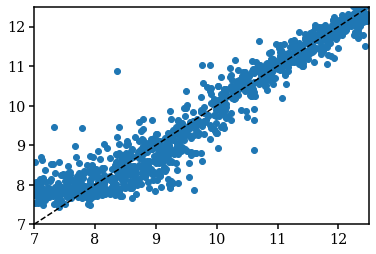

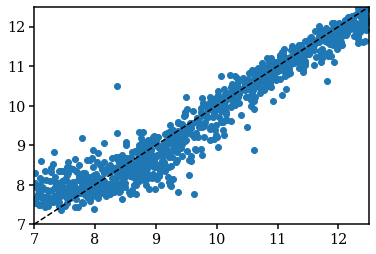

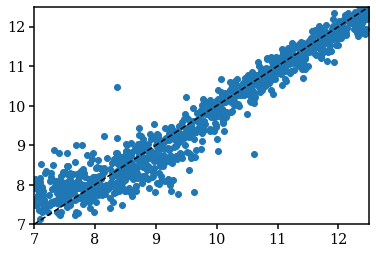

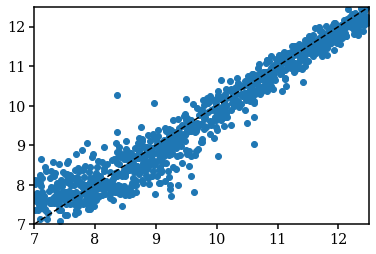

Stopping
====> Epoch: 35 TRAINING Loss: 7.80e-01 VALIDATION Loss: 5.12e-01


In [21]:
best_epoch = 0
best_valid_loss = np.inf
train_losses, valid_losses = [], []

t = trange(epochs, leave=False)
for epoch in t:
    spencoder.train()
    train_loss = 0
    for batch in train_loader:
        __spec, _Aspec, _ivar, _Aivar, _zred, _theta = batch
        __spec = __spec.to(device)
        _Aspec = _Aspec.to(device)
        _ivar = _ivar.to(device)
        _Aivar = _Aivar.to(device)
        _zred = _zred.to(device)
        _theta = _theta.to(device)
        optimizer.zero_grad()

        loss = F.mse_loss(_theta, spencoder.forward(__spec, _Aspec, _ivar, _Aivar, _zred))
        loss.backward()
        train_loss += loss.item()
        
        #torch.nn.utils.clip_grad_norm_(spencoder.parameters(), 1)
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    with torch.no_grad():
        valid_loss = 0
        for val_batch in valid_loader:
            __spec, _Aspec, _ivar, _Aivar, _zred, _theta = batch
            __spec = __spec.to(device)
            _Aspec = _Aspec.to(device)
            _ivar = _ivar.to(device)
            _Aivar = _Aivar.to(device)
            _zred = _zred.to(device)
            _theta = _theta.to(device)

            _loss = F.mse_loss(_theta, spencoder.forward(__spec, _Aspec, _ivar, _Aivar, _zred)) #torch.mean(_loss)
            valid_loss += _loss.item()
        valid_loss /= len(valid_loader)
        if np.isnan(valid_loss): raise ValueError
        valid_losses.append(valid_loss)

    scheduler.step()

    t.set_description('Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % (epoch, train_loss, valid_loss), refresh=False)
    
    if epoch % 10 == 0: 
        with torch.no_grad(): 
            _theta_pred = spencoder.forward(
                _spec[Ntrain:Ntrain+1000,:].to(device), 
                torch.from_numpy(norm[Ntrain:Ntrain+1000,None].astype(np.float32)).to(device), 
                torch.from_numpy(ivar[Ntrain:Ntrain+1000,:].astype(np.float32)).to(device),
                torch.from_numpy(norm_ivar[Ntrain:Ntrain+1000,None].astype(np.float32)).to(device),
                torch.from_numpy(zred[Ntrain:Ntrain+1000,None].astype(np.float32)).to(device))

            plt.scatter(theta[Ntrain:Ntrain+1000,0], _theta_pred.cpu().numpy()[:,0], c='C0')
            plt.plot([7., 12.5], [7., 12.5], c='k', ls='--')
            plt.xlim(7., 12.5)
            plt.ylim(7., 12.5)
            plt.show()
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        best_model = copy.deepcopy(spencoder)
        
    else:
        if epoch > best_epoch + patience:
            print('Stopping')
            print('====> Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % (epoch, train_loss, best_valid_loss))
            break

(0.0, 36.0)

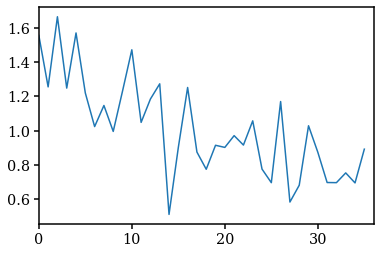

In [22]:
plt.plot(valid_losses)
plt.xlim(0, len(valid_losses))

In [23]:
with torch.no_grad(): 
    _theta_pred = spencoder.forward(
        _spec[Ntrain:Ntrain+1000,:].to(device), 
        torch.from_numpy(norm[Ntrain:Ntrain+1000,None].astype(np.float32)).to(device), 
        torch.from_numpy(ivar[Ntrain:Ntrain+1000,:].astype(np.float32)).to(device),
        torch.from_numpy(norm_ivar[Ntrain:Ntrain+1000,None].astype(np.float32)).to(device),
        torch.from_numpy(zred[Ntrain:Ntrain+1000,None].astype(np.float32)).to(device))

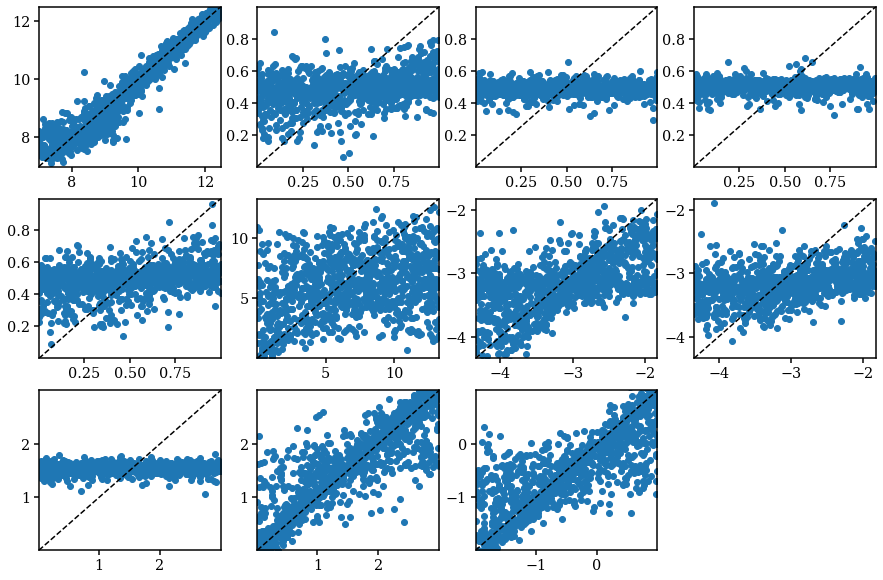

In [25]:
fig = plt.figure(figsize=(15, 10))
for i in range(11): 
    sub = fig.add_subplot(3, 4, i+1)
    sub.scatter(theta[Ntrain:Ntrain+1000,i], _theta_pred.cpu().numpy()[:,i], c='C0')
    sub.plot([theta[Ntrain:Ntrain+1000,i].min(), theta[Ntrain:Ntrain+1000,i].max()], 
             [theta[Ntrain:Ntrain+1000,i].min(), theta[Ntrain:Ntrain+1000,i].max()], c='k', ls='--')
    sub.set_xlim([theta[Ntrain:Ntrain+1000,i].min(), theta[Ntrain:Ntrain+1000,i].max()])
    sub.set_ylim([theta[Ntrain:Ntrain+1000,i].min(), theta[Ntrain:Ntrain+1000,i].max()])
plt.show()